In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data import get_data, get_run_path
from datasets import CIFAR_simclr, ActiveDataset
import os
import matplotlib
import scipy

In [2]:
# import shutil
# root= "/Users/victoriabarenne/thesis_experiments/pc_runs/"
# for subdir, dirs, files in os.walk(root):
#     for file in files:
#         if file in ["pc_radiuses.npy"]:
#             a= np.load(subdir+"/"+file)
#             print(a.shape)
#
#     # if len(files)<5 and len(subdir)>60:
#         # split= subdir.split("/")[-1]
#         # split= split.split("_")
#         # n_epochs, gamma, sd= split[0], split[4][5:], split[-1]
#            # np.save(subdir+ "/"+ file, a[0,:])
#             # np.save(subdir+ "/"+ file, a[0,0])
#             # os.rmdir(subdir)
#
#


In [3]:
# import shutil
#
# def get_new_dir_name(subdir):
#     split_dir= subdir.split("/")
#     folder=split_dir[-1]
#     n_epochs= folder.split("_")[0]
#     root= ""
#     for chunk in split_dir[:-1]:
#         root= root+chunk+"/"
#     root =root+"100"
#     split_subdir= split_dir[-1].split("_")
#     for chunk in split_subdir[1:]:
#         root= root +"_"+ chunk
#     return root
#
# for subdir, dirs, files in os.walk("/Users/victoriabarenne/thesis_experiments/toy_runs/"):
#     if len(files)>1:
#         folder=subdir.split("/")[-1]
#         n_epochs= folder.split("_")[0]
#         if n_epochs!="100":
#             print(subdir, n_epochs)
#             # print(get_new_dir_name(subdir))
#             # shutil.move(subdir, get_new_dir_name(subdir))
#


In [4]:
# for subdir, dirs, files in os.walk("/Users/victoriabarenne/thesis_experiments/pc_runs/cifar10/"):
#     if len(subdir)==63:
#         n_epochs= subdir[58:61]
#         sd= subdir[-1]
#         new_name= f"/Users/victoriabarenne/thesis_experiments/pc_runs/cifar10/{n_epochs}_0.95_{sd}"
#         os.rename(subdir, new_name)
#     elif len(subdir)==64:
#         n_epochs= subdir[58:62]
#         sd= subdir[-1]
#         new_name= f"/Users/victoriabarenne/thesis_experiments/pc_runs/cifar10/{n_epochs}_0.95_{sd}"
#         os.rename(subdir, new_name)
# for subdir, dirs, files in os.walk("/Users/victoriabarenne/thesis_experiments/pc_runs/cifar100/"):
#     if len(subdir)==64:
#         n_epochs= subdir[59:62]
#         sd= subdir[-1]
#         new_name= f"/Users/victoriabarenne/thesis_experiments/pc_runs/cifar100/{n_epochs}_0.95_{sd}"
#         os.rename(subdir, new_name)
#     elif len(subdir)==65:
#         n_epochs= subdir[59:63]
#         sd= subdir[-1]
#         new_name= f"/Users/victoriabarenne/thesis_experiments/pc_runs/cifar100/{n_epochs}_0.95_{sd}"
#         os.rename(subdir, new_name)


In [5]:
def get_cifar_data(args):
    dataset= CIFAR_simclr(args.dataset, args.n_epochs, train=True, cluster=False)
    dataset_test= CIFAR_simclr(args.dataset, args.n_epochs, train=False, cluster=False)

    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10))) #15000
    if args.dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20))) #25000
    if args.budget=="high":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 30))) # 30000 or 40000

    if args.budget=="full":
        eval_freq= np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                np.repeat(200,20), np.repeat(500, 10),
                                   np.repeat(500,70))) # full 50000

    idx = np.cumsum(eval_freq)
    return dataset, dataset_test, idx

def get_cifar_path(args):
    path_root= f"/Users/victoriabarenne/{args.run}/{args.dataset}"
    if args.algorithm =="adpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_gamma{args.gamma}_{args.reduction_method}_{args.sd}"
    elif args.algorithm =="partialadpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_gamma{args.gamma}_{args.reduction_method}_{args.sd}"
    elif args.algorithm in ["benchmark", "random", "full"]:
        run_path= f"{path_root}/{args.n_epochs}_{args.sd}"
    elif args.algorithm == "pc":
        run_path= f"{path_root}/{args.n_epochs}_{args.tsh}_{args.sd}"
    elif args.algorithm == "coverpc":
        run_path= f"{path_root}/{args.n_epochs}_4_{args.tsh}_{args.hard_thresholding}_eps{args.eps}_cover{args.cover_threshold}_{args.sd}"
    return run_path

def fetching_run(args):
    run_path= get_cifar_path(args)
    assert(args.algorithm in ["full", "random", "pc", "adpc", "partialadpc", "coverpc"])
    if args.algorithm=="full":
        scores = pd.read_csv(run_path + f"/full.csv", index_col=0)[f"full_scores"].to_numpy()
        queries, radiuses, degrees, options, covers = None, None, None, None, None
    else:
        scores = pd.read_csv(run_path + f"/{args.algorithm}_scores.csv", index_col=0)[f"{args.algorithm}_scores"].to_numpy()
        queries = pd.read_csv(run_path + f"/{args.algorithm}_queries.csv", index_col=0)[f"{args.algorithm}_queries"].to_numpy()
        if args.algorithm in ["pc", "adpc", "partialadpc", "coverpc"]:
            radiuses= np.load(f'{run_path}/{args.algorithm}_radiuses.npy')
            degrees = pd.read_csv(run_path + f"/{args.algorithm}_degrees.csv", index_col=0)[f"{args.algorithm}_degrees"].to_numpy()
            options = pd.read_csv(run_path + f"/{args.algorithm}_degrees.csv", index_col=0)[f"{args.algorithm}_options"].to_numpy()
            covers = pd.read_csv(run_path + f"/{args.algorithm}_covers.csv", index_col=0)[f"{args.algorithm}_covers"].to_numpy()
        else:
            radiuses, degrees, options, covers= None, None, None, None

    return scores, queries, radiuses, degrees, options, covers

def fetching_aggregated_run(args, n_seeds=5):
    _,_,idx= get_cifar_data(args)
    n_saves= len(idx)
    n_queries= idx[-1]

    scores, queries= np.empty(shape=(n_saves, n_seeds)), np.empty(shape=(n_queries, n_seeds))
    if args.algorithm=="adpc":
        radiuses= np.empty(shape=(50000, n_saves, n_seeds))
    elif args.algorithm=="pc":
        radiuses= np.empty(shape=(n_seeds,))
    elif args.algorithm=="coverpc":
        radiuses= np.empty(shape=(n_saves,n_seeds))
    else:
        radiuses= None
    degrees, options= np.empty(shape= (n_queries, n_seeds)), np.empty(shape= (n_queries, n_seeds))
    covers= np.empty(shape=(n_saves, n_seeds))
    for sd in range(n_seeds):
        args.sd=sd+1
        sco, que, rad, deg, opt, cov= fetching_run(args)
        scores[:,sd] = sco[:n_saves]
        if args.algorithm!="full":
            queries[:,sd]= que[:n_queries]
        if args.algorithm in ["adpc", "pc", "coverpc"]:
            degrees[:,sd], options[:,sd], covers[:,sd] = deg[:n_queries], opt[:n_queries], cov[:n_saves]
            if args.algorithm =="adpc":
                radiuses[:,:,sd]= rad[:,:n_saves]
            elif args.algorithm=="pc":
                radiuses[sd]= rad
            elif args.algorithm=="coverpc":
                radiuses[:,sd]= rad[:n_saves]
    return scores, queries, radiuses, degrees, options, covers


In [6]:
def get_ci(y, n_seeds, confidence=0.95):
    t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=n_seeds - 1)
    sd = np.std(y, axis=-1, ddof=1)
    se = sd / np.sqrt(n_seeds)

    ci_low = y.mean(-1) - t_value * se
    ci_up = y.mean(-1) + t_value * se

    return y.mean(-1), ci_low, ci_up, t_value*se


In [7]:
def add_score_line(args, label, n_seeds= 5, color=None, type="scores", confidence=0.95):
    scores, _, radiuses, degrees, options, covers= fetching_aggregated_run(args, n_seeds=n_seeds)
    if type in ["degrees", "options"]:
        y = degrees if type=="degrees" else options
        idx = np.arange(1, len(degrees)+1)
    elif type in ["scores", "covers"]:
        _, _, idx= get_cifar_data(args)
        y= scores if type=="scores" else covers

    mean, ci_low, ci_up, _ = get_ci(y, n_seeds=n_seeds, confidence=confidence)

    sns.lineplot(x=idx, y=mean, label= label, color=color, linewidth= 2)
    plt.fill_between(idx, ci_low, ci_up, alpha=0.5, color=color)

In [8]:
def add_table_line(args, label, indices, n_seeds=5, confidence=0.95):
    scores, _, _, _, _, _= fetching_aggregated_run(args, n_seeds=n_seeds)
    means, _, _, cis_length= get_ci(scores, n_seeds= n_seeds, confidence=confidence)
    means, cis_length= means[indices], cis_length[indices]

    row= []
    row.append(label)
    for i, mean in enumerate(means):
        row.append(f"{round(mean,4)}(+-{round(cis_length[i],4)})")

    return row

def plot_scores_table(dataset, n_epochs, arguments:np.array, labels:np.array, percentages=None):
    args= pd.Series({"dataset": dataset, "n_epochs": n_epochs, "budget":"low"})
    if percentages is None:
        percentages= [0.01, 0.02, 0.05, 0.1, 0.14, 0.2, 0.3] if dataset=="cifar10" else [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

    dataset, _, idx= get_cifar_data(args)
    indices, field_names = [], ["Active learning method"]
    for perc in percentages:
        indices.append(np.where(idx==int(perc*dataset.n_points))[0].item())
        field_names.append(f"{round(perc*100, 2)}%")

    x = PrettyTable()
    x.field_names= field_names
    for i in range(len(labels)):
        row= add_table_line(arguments[i], labels[i], indices, n_seeds=5)
        x.add_row(row)
    return x


In [9]:
args= pd.Series({
    "dataset":"cifar10",
    "separable":"not",
    "algorithm":"coverpc",
    "sd":1,
    "gamma":0.5,
    "tsh":0.25,
    "hard_thresholding":"False",
    "running_cluster":"False",
    "run":"thesis_experiments/coverpc_runs",
    "budget":"low",
    "n_epochs":1000,
    "n_points":1000,
    "std":0.5,
    "eps":0.9,
    "cover_threshold":0.5,
    "reduction_method": "pessimistic",
    })


## Coverpc Runs

In [55]:
def plot_coverpc_runs(args, n_epochs, type="scores", save=False, zoom=False):
    args.n_epochs=n_epochs
    args_coverpc, args_pc= args.copy(), args.copy()
    args_coverpc.algorithm, args_coverpc.hardthresholding, args_coverpc.tsh, args_coverpc.run= "coverpc", "False", 0.25, "thesis_experiments/coverpc_runs"
    args_pc.algorithm, args_pc.tsh, args_pc.run= "pc", 0.95, "thesis_experiments/pc_runs"
    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = "/Users/victoriabarenne/thesis_plots/cifar_coverpc/zoom/"
    else:
        save_root = "/Users/victoriabarenne/thesis_plots/cifar_coverpc/"
    location = {"scores": "lower right",
        "covers": "upper left",
        "degrees": "upper right",
        "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}
    colors= [cmap.colors[2], cmap.colors[4], cmap.colors[5]]
    for cover_threshold in [0.3, 0.4, 0.5]:
        args_coverpc.cover_threshold=cover_threshold
        add_score_line(args_pc, "PC", type=type, color= cmap.colors[3])
        i=0
        for eps in [0.7, 0.8, 0.9]:
            args.eps= eps
            add_score_line(args_coverpc, f"Cover {cover_threshold} and eps {eps}", type=type, color=colors[i])
            i+=1

        plt.legend(loc=location[type])
        plt.xlabel("Number of queries")
        plt.ylabel(ylabel[type])

        if type=="scores":
            if zoom:
                plt.xlim(500, 15000)
                (ymin, ymax)= (0.6, 0.9)
                plt.ylim(ymin, ymax)
                plt.xscale("log")
            else:
                (ymin, ymax)= (0, 0.9)
                plt.ylim(ymin,ymax)
                plt.xscale("log")
        elif type=="covers":
            (ymin, ymax)= (0, 0.8)
            plt.ylim(ymin,ymax)
        elif type=="degrees":
            (ymin, ymax)= (0, 40)
            plt.ylim(ymin, ymax)
        elif type=="options":
            plt.ylim(0)

        if save:
            plt.savefig(save_root + f"{args.n_epochs}_cover_threshold{cover_threshold}_{type}.png")
            plt.close()
        else:
            plt.title(f"{args.n_epochs}epochs_cover_threshold{cover_threshold}_{type}")
            plt.show()

    add_score_line(args_pc, "PC", type=type, color= cmap.colors[3])
    i=0
    args_coverpc.eps=0.9
    for cover_threshold in [0.3, 0.4, 0.5]:
        args_coverpc.cover_threshold=cover_threshold
        add_score_line(args_coverpc, f"Cover {cover_threshold} and eps {eps}", type=type, color=colors[i])
        i+=1
    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if type=="scores":
        if zoom:
            plt.xlim(500, 15000)
            (ymin, ymax)= (0.6, 0.9)
            plt.ylim(ymin, ymax)
            plt.xscale("log")
        else:
            (ymin, ymax)= (0, 0.9)
            plt.ylim(ymin,ymax)
            plt.xscale("log")
    elif type=="covers":
        (ymin, ymax)= (0, 0.8)
        plt.ylim(ymin,ymax)
    elif type=="degrees":
        (ymin, ymax)= (0, 40)
        plt.ylim(ymin, ymax)
    elif type=="options":
        plt.ylim(0)

    if save:
        plt.savefig(save_root + f"{args.n_epochs}_eps{eps}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_eps{eps}_{type}")
        plt.show()



In [ ]:
save= False
zoom= False
args.dataset=="cifar10"
# for type in ["scores", "covers", "degrees", "options"]:
for type in ["scores"]:
    for n_epochs in [100,200,400,1000]:
        plot_coverpc_runs(args, n_epochs, type=type, save=save, zoom=zoom)

## Kmeans radiuses vs True radiuses

In [ ]:
from clustering import MyKMeans
from utils.hyperparameters import get_init_radiuses, floor_twodecimals

def plot_pc_radiuses(args, oracle=False, save_path="/Users/victoriabarenne/thesis_plots/kmeans_radiuses"):
    if not os.path.exists(f"{save_path}/{args.dataset}"):
        os.makedirs(f"{save_path}/{args.dataset}")

    dataset, dataset_test, eval_points = get_cifar_data(args)

    if args.sd is not None:
        np.random.seed(args.sd)
    n_classes = len(np.unique(dataset.y))
    if oracle:
        pseudo_labels= dataset.y
    else:
        clustering = MyKMeans(dataset, n_classes)
        pseudo_labels = clustering.pseudo_labels

    rad, radiuses = get_init_radiuses(0.95, dataset, pseudo_labels)
    rad25= floor_twodecimals(np.quantile(radiuses, 1-0.25))
    print(rad, rad25)
    #histograms
    fig, ax = plt.subplots()
    if args.dataset== "cifar10":
        ax.set_xlim((0, 1.2))
        ax.set_ylim((0, 0.3))
    sns.histplot(x=radiuses, stat="probability", bins=15)
    ax.set_xlabel("Radius")
    ax.set_ylabel("Probability")
    ax.axvline(rad, color='r', linestyle='dashed', linewidth=1)
    ax.axvline(rad25, color='r', linestyle='dashed', linewidth=1)

    ax.text(rad + 0.01, 0.28, f"{rad}", size=15, alpha=1, color='r')
    ax.text(rad25 + 0.01, 0.28, f"{rad25}", size=15, alpha=1, color='r')
    if save:
        plt.savefig(f'{save_path}/{args.dataset}/{args.n_epochs}epochs_{oracle}.png')
        plt.close()
    else:
        plt.show()
        plt.title(f'{args.dataset} {args.n_epochs}epochs {oracle}')


In [ ]:
for oracle in [True, False]:
    for n_epochs in [100, 200, 400, 1000]:
        args.n_epochs= n_epochs
        plot_pc_radiuses(args, oracle=oracle)

## Gamma Runs


In [58]:
def plot_gamma_runs(args, n_epochs, type="scores", save=False, figsize= None, save_root= "/Users/victoriabarenne/thesis_plots/cifar_gamma/"):
    args.n_epochs, args.dataset, args.gamma, args.hard_thresholding = n_epochs, "cifar10", 0.5, "False"
    args_adpc, args_pc= args.copy(), args.copy()
    args_adpc.algorithm, args_adpc.tsh, args_adpc.hard_thresholding, args_adpc.run= "adpc", 0.25, "True", "thesis_experiments/adpc_runs"
    args_gamma = args_adpc.copy()
    args_gamma.hard_thresholding, args_gamma.run = "False", "thesis_experiments/gamma_runs"
    args_pc.algorithm, args_pc.tsh, args_pc.run= "pc", 0.95, "thesis_experiments/pc_runs"
    cmap=matplotlib.colormaps["Set2"]

    if figsize is not None:
        plt.figure(figsize=figsize) # for the extra zoom

    add_score_line(args_adpc, "AdaptivePC", type=type, color= cmap.colors[2])
    args_adpc.hard_thresholding= False
    add_score_line(args_adpc, "AdaptivePC without hard thresholding", type=type, color= cmap.colors[1])
    # add_score_line(args_pc, "PC", type=type, color= cmap.colors[3])
    i=3
    for gamma in [0.125, 0.25, 0.325]:
        args_gamma.gamma=gamma
        add_score_line(args_gamma, f"Adaptive PC with gamma {args_gamma.gamma}", type=type, color=cmap.colors[i])
        i+=1
    location = {"scores": "lower right",
                "covers": "upper left",
                "degrees": "upper right",
                "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])
    if type in ["scores", "covers"] :
        (ymin, ymax) = (0.1, 0.9) if type=="scores" else (0, 0.7)
        # (ymin, ymax) = (0.1, 0.75) if type=="scores" else (0, 0.55)
        plt.ylim(ymin, ymax)
        plt.xscale("log")
    elif type=="options":
        plt.ylim(0)
    elif type=="degrees":
        plt.ylim(0)

    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}_{type}")
        plt.show()



In [ ]:
save= False
type="scores"
n_epochs=100
for type in ["scores", "covers", "degrees", "options"]:
    figsize= (6, 5) if type in ["scores", "covers"] else (8,5)
    for n_epochs in [100]:
    # for n_epochs in [100, 400, 1000]:
        plot_gamma_runs(args, n_epochs, type=type, save=save, figsize= figsize)

## Performance: Accuracy, Coverage, Degrees, Option

In [10]:
def plot_cifar_performance(args, dataset, n_epochs, type="degrees", save=False, zoom=False):
    args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh= dataset, n_epochs, "False", "low", 0.5, "pessimistic", 0.5, 0.9, 0.25
    args_adpc, args_coverpc, args_pc, args_random, args_full= args.copy(), args.copy(), args.copy(), args.copy(), args.copy()
    args_adpc.algorithm, args_adpc.run, args_adpc.hard_thresholding= "adpc", "thesis_experiments/adpc_runs", "True"
    args_coverpc.algorithm, args_coverpc.run= "coverpc", "thesis_experiments/coverpc_runs"
    args_pc.algorithm, args_pc.run, args_pc.tsh= "pc", "thesis_experiments/pc_runs", 0.95
    args_random.algorithm, args_random.run= "random", "thesis_experiments/benchmark_runs"
    args_full.algorithm, args_full.run= "full", "thesis_experiments/benchmark_runs"

    # plt.figure(figsize=(8,3)) # for the extra zoom

    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = f"/Users/victoriabarenne/thesis_plots/cifar_performance/zoom/"
    else:
        save_root = f"/Users/victoriabarenne/thesis_plots/cifar_performance/"

    add_score_line(args_adpc, "Adaptive PC", type=type, color=cmap.colors[2])
    add_score_line(args_pc, "PC", type=type, color=cmap.colors[3])
    add_score_line(args_coverpc, "Dynamic PC", type=type, color=cmap.colors[4])
    if type=="scores":
        add_score_line(args_random, "Random", type=type, color=cmap.colors[-2])
        add_score_line(args_full, "Oracle", type=type, color= cmap.colors[-1])
    if type in ["scores", "covers"] and not zoom:
        plt.xscale("log")

    location= {"scores": "lower right",
              "covers": "upper left",
               "degrees": "upper right",
               "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if type=="scores":
        (ymin, ymax)= (0.0, 0.9) if dataset=="cifar10" else (0.0, 0.6)
    elif type=="covers":
        ymax= 0.8 if dataset=="cifar10" else 0.75
        ymin=0.0
    elif type=="degrees":
        ymax= 40 if dataset=="cifar10" else 30
        ymin=0


    if zoom and type in ["scores"]:
        plt.xlim(3000, 15000)
        (ymin, ymax)=(0.6, 0.9) if dataset=="cifar10" else (0.25, 0.6)
        plt.ylim(ymin, ymax)
    elif type in ["scores", "covers", "degrees"]:
        plt.ylim(ymin,ymax)
    elif type=="options":
        plt.ylim(0)


    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_{type}")
        plt.show()

In [14]:
save=True
zoom= False
type="covers"

for dataset in ["cifar10", "cifar100"]:
    for n_epochs in [100,200,400,1000]:
        plot_cifar_performance(args, dataset, n_epochs, type=type, save=save, zoom=zoom)

## Accuracy tables for CIFAR10 and CIFAR100


In [61]:
from prettytable import PrettyTable
n_points= 50000
dataset= "cifar10"
n_epochs = 100

def plot_scores_table_here(args, n_epochs, dataset):
    percentages= [0.01, 0.02, 0.05, 0.1, 0.14, 0.2, 0.3] if dataset=="cifar10" else [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

    args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh= dataset, n_epochs, "False", "low", 0.5, "pessimistic", 0.5, 0.9, 0.25
    args_adpc, args_coverpc, args_pc, args_random= args.copy(), args.copy(), args.copy(), args.copy()
    args_adpc.algorithm, args_adpc.run, args_adpc.hard_thresholding= "adpc", "thesis_experiments/adpc_runs", "True"
    args_coverpc.algorithm, args_coverpc.run= "coverpc", "thesis_experiments/coverpc_runs"
    args_pc.algorithm, args_pc.run, args_pc.tsh= "pc", "thesis_experiments/pc_runs", 0.95
    args_random.algorithm, args_random.run= "random", "thesis_experiments/benchmark_runs"
    _, _, idx= get_cifar_data(args)
    indices = []
    for perc in percentages:
        indices.append(np.where(idx==int(perc*n_points))[0].item())
    arguments= [args_adpc, args_coverpc, args_pc, args_random]
    labels= ["AdaptivePC", "DynamicPC", "PC", "random"]
    x = PrettyTable()
    x.field_names = ["Active learning method", "1%", "2%", "5%", "10%", "14%", "20%", "30%"] if dataset=="cifar10" else ["Active learning method", "1%", "5%", "10%", "20%", "30%", "40%", "50%"]
    for i in range(4):
        row= add_table_line(arguments[i], labels[i], indices, n_seeds=5)
        x.add_row(row)
    return x


In [93]:
## OLD USING STD: DO NOT RERUN!!
x= plot_scores_table(args, 100, "cifar10")
print(x)

+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
| Active learning method |        1%        |        2%        |        5%        |       10%        |       14%        |       20%        |       30%        |
+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       AdaptivePC       | 0.6646(+-0.0019) | 0.6693(+-0.0022) | 0.6857(+-0.0014) | 0.6977(+-0.0015) | 0.7038(+-0.0018) | 0.7128(+-0.0022) | 0.7231(+-0.0012) |
|       DynamicPC        | 0.6556(+-0.003)  | 0.6732(+-0.003)  | 0.6881(+-0.0031) | 0.7036(+-0.0031) | 0.7104(+-0.0015) | 0.7142(+-0.0024) | 0.7176(+-0.0028) |
|           PC           | 0.6388(+-0.0031) | 0.6642(+-0.0016) | 0.6835(+-0.0017) | 0.698(+-0.0016)  | 0.7004(+-0.0023) | 0.709(+-0.0014)  | 0.7148(+-0.0011) |
|         random         | 0.6056(+-0.00

In [62]:
x= plot_scores_table_here(args, 100, "cifar10")
print(x)

+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
| Active learning method |        1%        |        2%        |        5%        |       10%        |       14%        |       20%        |       30%        |
+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       AdaptivePC       | 0.6646(+-0.0026) | 0.6693(+-0.003)  | 0.6857(+-0.0019) | 0.6977(+-0.0021) | 0.7038(+-0.0025) | 0.7128(+-0.0031) | 0.7231(+-0.0017) |
|       DynamicPC        | 0.6556(+-0.0042) | 0.6732(+-0.0041) | 0.6881(+-0.0043) | 0.7036(+-0.0043) | 0.7104(+-0.0021) | 0.7142(+-0.0033) | 0.7176(+-0.0039) |
|           PC           | 0.6388(+-0.0043) | 0.6642(+-0.0023) | 0.6835(+-0.0023) | 0.698(+-0.0023)  | 0.7004(+-0.0032) |  0.709(+-0.002)  | 0.7148(+-0.0015) |
|         random         | 0.6056(+-0.00

## PC for different radiuses

In [99]:
def plot_pc_performance(args, n_epochs, type="degrees", save=False, zoom=False, figsize=None, get_scores_table= False):
    args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh= "cifar10", n_epochs, "False", "low", 0.5, "pessimistic", 0.5, 0.9, 0.95
    args_pc, args_random= args.copy(), args.copy()
    args_pc.algorithm, args_pc.run, args_pc.tsh= "pc", "thesis_experiments/pc_runs", 0.95
    args_random.algorithm, args_random.run= "random", "thesis_experiments/benchmark_runs"
    if figsize is not None:
        plt.figure(figsize=figsize) # for the extra zoom

    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = f"/Users/victoriabarenne/thesis_plots/cifar_pc/zoom/"
    else:
        save_root = f"/Users/victoriabarenne/thesis_plots/cifar_pc/"

    i=1
    for tsh in [0.5, 0.75, 0.95, 0.25, 0.05]:
        args_pc.tsh= tsh
        add_score_line(args_pc, f"PC with {args_pc.tsh} purity threshold", type=type, color=cmap.colors[i])
        i+=1
    if type=="scores":
        add_score_line(args_random, f"Random", type=type, color=cmap.colors[i])


    if type in ["scores", "covers"] and not zoom:
        plt.xscale("log")

    location= {"scores": "lower right",
              "covers": "upper left",
               "degrees": "upper right",
               "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if zoom and type in ["scores"]:
        (ymin, ymax)= (0.82, 0.9)
        plt.xlim(3000, 15000)
        plt.ylim(ymin, ymax)
    elif type in ["scores", "covers", "degrees"]:
        ymax={"scores":0.9, "covers":1.1, "degrees":40}
        plt.ylim(0,ymax[type])
    elif type=="options":
        plt.ylim(0)


    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_{type}")
        plt.show()

    if get_scores_table:
        arguments= [args_random]
        labels= ["Random"]
        for tsh in [0.5, 0.75, 0.95, 0.25, 0.05]:
            args_pc.tsh= tsh
            labels.append(f"PC with purity threshold {args_pc.tsh}")
            arguments.append(args_pc.copy())
        return plot_scores_table("cifar10", n_epochs, arguments, labels, percentages=[0.0001, 0.001, 0.005, 0.01, 0.05, 0.3])

In [124]:
save= True
zoom= False
figsize= None
type= "covers"
for n_epochs in [100 , 1000]:
    x= plot_pc_performance(args, n_epochs, type=type, save=save, zoom=zoom, figsize=figsize, get_scores_table= False)


In [101]:
x

Active learning method,0.01%,0.1%,0.5%,1.0%,5.0%,30.0%
Random,0.2539(+-0.0911),0.6856(+-0.0368),0.7905(+-0.0088),0.8152(+-0.0058),0.8395(+-0.0022),0.8632(+-0.0025)
PC with purity threshold 0.5,0.4269(+-0.0),0.8083(+-0.0007),0.8434(+-0.002),0.8437(+-0.004),0.8456(+-0.0007),0.8657(+-0.0023)
PC with purity threshold 0.75,0.4277(+-0.0),0.794(+-0.0002),0.8479(+-0.0011),0.856(+-0.0015),0.8544(+-0.0026),0.8625(+-0.0024)
PC with purity threshold 0.95,0.3616(+-0.0),0.6919(+-0.0007),0.829(+-0.0015),0.8474(+-0.0019),0.8634(+-0.0026),0.8659(+-0.0038)
PC with purity threshold 0.25,0.4253(+-0.0),0.8225(+-0.0001),0.8343(+-0.0024),0.8354(+-0.0031),0.8368(+-0.003),0.8635(+-0.0046)
PC with purity threshold 0.05,0.4662(+-0.0),0.7999(+-0.0017),0.8119(+-0.0011),0.8139(+-0.0038),0.8387(+-0.0032),0.8629(+-0.0023)


## ADPC Hard-thresholding

In [140]:
def plot_hardthresholding_performance(args, n_epochs, type="scores", save=False, zoom=False, figsize=None):
    args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh, args.algorithm, args.run= "cifar10", n_epochs, True, "low", 0.5, "pessimistic", 0.5, 0.9, 0.25,  "adpc", "thesis_experiments/adpc_runs"

    args_pc, args_random= args.copy(), args.copy()
    args_pc.algorithm, args_pc.tsh, args_pc.run= "pc", 0.95, "thesis_experiments/pc_runs"
    args_random.algorithm, args_random.run= "random", "thesis_experiments/benchmark_runs"


    if figsize is not None:
        plt.figure(figsize=figsize) # for the extra zoom

    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = f"/Users/victoriabarenne/thesis_plots/hard_thresholding/zoom/"
    else:
        save_root = f"/Users/victoriabarenne/thesis_plots/hard_thresholding/"


    add_score_line(args, f"AdaptivePC", type=type, color=cmap.colors[2])
    args.hard_thresholding= False
    add_score_line(args, f"AdaptivePC without hard thresholding", type=type, color=cmap.colors[5])
    add_score_line(args_pc, f"PC", type=type, color=cmap.colors[3])
    if type=="scores"  :
        add_score_line(args_random, f"Random", type=type, color=cmap.colors[6])

    if type in ["scores", "covers"] and not zoom:
        plt.xscale("log")

    location= {"scores": "lower right",
              "covers": "upper left",
               "degrees": "upper right",
               "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if zoom and type in ["scores"]:
        (ymin, ymax)= (0.82, 0.9)
        plt.xlim(3000, 15000)
        plt.ylim(ymin, ymax)
    elif type in ["scores", "covers", "degrees"]:
        ymax={"scores":0.9, "covers":1.1, "degrees":1500}
        plt.ylim(0,ymax[type])
    elif type=="options":
        plt.ylim(0)



    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_{type}")
        plt.show()


In [142]:
save= True
type= "degrees"
n_epochs=100
for n_epochs in [100,200,400,1000]:
    # for type in ["scores", "covers"]:
    plot_hardthresholding_performance(args, n_epochs, type=type, save= save)

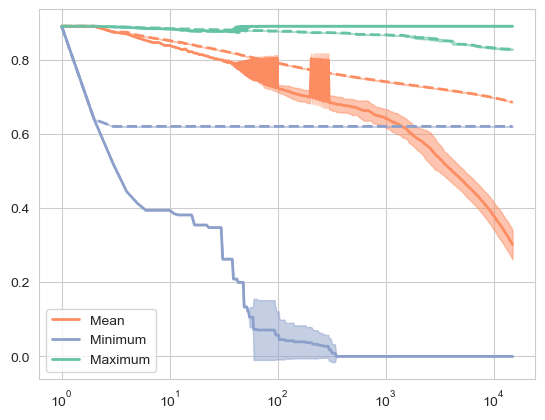

In [46]:
n_epochs= 1000
save= False
args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh, args.algorithm, args.run= "cifar10", n_epochs, False, "low", 0.5, "pessimistic", 0.5, 0.9, 0.25,  "adpc", "thesis_experiments/adpc_runs"
labels= ["Mean", "Minimum", "Maximum"]

cmap2= matplotlib.colormaps["Set2"].colors
cmap2= [cmap2[1], cmap2[2], cmap2[0]]
_, _, idx = get_cifar_data(args)

scores, _, radiuses, degrees, options, covers= fetching_aggregated_run(args, n_seeds=5)
radiuses_mean, radiuses_min, radiuses_max= radiuses.mean(0), radiuses.min(0), radiuses.max(0)

for i, rads in enumerate([radiuses_mean, radiuses_min, radiuses_max]):
    mean, ci_low, ci_up, _ = get_ci(rads, n_seeds=5, confidence=0.95)
    sns.lineplot(x=idx, y=mean, label= labels[i], color=cmap2[i], linewidth= 2)
    plt.fill_between(idx, ci_low, ci_up, alpha=0.5, color=cmap2[i])

args.hard_thresholding= True
scores, _, radiuses, degrees, options, covers= fetching_aggregated_run(args, n_seeds=5)
radiuses_mean, radiuses_min, radiuses_max= radiuses.mean(0), radiuses.min(0), radiuses.max(0)
for i, rads in enumerate([radiuses_mean, radiuses_min, radiuses_max]):
    mean, ci_low, ci_up, _ = get_ci(rads, n_seeds=5, confidence=0.95)
    sns.lineplot(x=idx, y=mean, color=cmap2[i], linewidth= 2, linestyle= "dashed")
    plt.fill_between(idx, ci_low, ci_up, alpha=0.5, color=cmap2[i])
plt.xscale("log")
#     add_score_line(args, "", n_seeds= 5, color=None, type="radiuses", confidence=0.95)
save_root = f"/Users/victoriabarenne/thesis_plots/hard_thresholding/"
plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_radiuses.png")

## ADPC different thresholds


In [86]:
def plot_adpc_tsh(args, n_epochs, type="scores", save=False, zoom=False, figsize=None):
    args.dataset, args.n_epochs, args.hard_thresholding, args.budget, args.gamma, args.reduction_method, args.cover_threshold, args.eps, args.tsh, args.algorithm, args.run= "cifar10", n_epochs, True, "low", 0.5, "pessimistic", 0.5, 0.9, 0.25,  "adpc", "thesis_experiments/adpc_runs"

    if figsize is not None:
        plt.figure(figsize=figsize) # for the extra zoom

    cmap=matplotlib.colormaps["Set2"]
    if zoom:
        save_root = f"/Users/victoriabarenne/thesis_plots/adpc_tsh/zoom?"
    else:
        save_root = f"/Users/victoriabarenne/thesis_plots/adpc_tsh/"

    add_score_line(args, f"AdaptivePC", type=type, color=cmap.colors[2])
    args.algorithm, args.tsh, args.run= "pc", 0.95, "thesis_experiments/pc_runs"
    add_score_line(args, f"PC", type=type, color=cmap.colors[3])
    i=4
    for tsh in [0.05, 0.5, 0.75]:
        args.tsh=tsh
        if i==6:
            i=1
        add_score_line(args, f"AdaptivePC with purity threshold {args.tsh}", type=type, color=cmap.colors[i])
        i+=1

    if type=="scores"  :
        args.algorithm, args.run="random", "thesis_experiments/benchmark_runs/"
        add_score_line(args, f"Random", type=type, color=cmap.colors[6])
        args.algorithm="full"
        add_score_line(args, f"Oracle", type=type, color=cmap.colors[7])

    if type in ["scores", "covers"] and not zoom:
        plt.xscale("log")

    location= {"scores": "lower right",
              "covers": "upper left",
               "degrees": "upper right",
               "options": "upper left"}
    ylabel= {"scores": "Accuracy",
              "covers": "Coverage",
             "degrees": "Out degree of the selected query",
             "options": "Number of options with same out degree"}

    plt.legend(loc=location[type])
    plt.xlabel("Number of queries")
    plt.ylabel(ylabel[type])

    if zoom and type in ["scores"]:
        if n_epochs==1000:
            (ymin, ymax)= (0.82, 0.9)
        else:
            (ymin, ymax)= (0.6, 0.76)
        plt.xlim(3000, 15000)
        plt.ylim(ymin, ymax)
    elif type in ["scores", "covers", "degrees"]:
        ymax={"scores":0.9, "covers":1.1, "degrees":40}
        plt.ylim(0,ymax[type])
    elif type=="options":
        plt.ylim(0)

    if save:
        plt.savefig(save_root + f"{args.n_epochs}_{args.dataset}_{type}.png")
        plt.close()
    else:
        plt.title(f"{args.n_epochs}epochs_{type}")
        plt.show()


In [91]:
save= True
type ="scores"
n_epochs =100
figsize=None
for type in ["covers", "degrees", "options"]:
    for n_epochs in [100,1000]:
        plot_adpc_tsh(args, n_epochs, type=type, save=save, figsize=figsize, zoom=False)
